In [36]:
import pandas as pd
from pyvi import ViTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def vn_tokenizer(text):
    return ViTokenizer.tokenize(text).split()

def yield_tokens(data_iter, tokenizer):
    for text in data_iter:
        yield tokenizer(text)

def build_vocab(data_iter, tokenizer, min_freq=2, specials=['<unk>', '<pad>'], max_tokens=1000):
    counter = Counter()
    for tokens in yield_tokens(data_iter, tokenizer):
        counter.update(tokens)

    # Giữ lại các từ thỏa mãn điều kiện
    vocab_tokens = specials + [word for word, freq in counter.items() if freq >= min_freq]
    vocab_tokens = vocab_tokens[:max_tokens]

    vocab = {word: idx for idx, word in enumerate(vocab_tokens)}
    vocab['<unk>'] = vocab.get('<unk>', 0)
    vocab['<pad>'] = vocab.get('<pad>', 1)

    return vocab

In [38]:
train_df = pd.read_csv(r'./cleaned_data/train.csv', quotechar='"', encoding='utf-8')
valid_df = pd.read_csv(r'./cleaned_data/valid.csv', quotechar='"', encoding='utf-8')
test_df = pd.read_csv(r'./cleaned_data/test.csv', quotechar='"', encoding='utf-8')
full_df = pd.concat([train_df, valid_df, test_df])

In [39]:
vocab_size = 1000
vocabulary = build_vocab(full_df['sentence'], vn_tokenizer, min_freq=2, max_tokens=vocab_size)

In [40]:
vocab_size = 1000
vocabulary = build_vocab(train_df['sentence'], vn_tokenizer, min_freq=2, max_tokens=vocab_size)

In [41]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, vocab):
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.vocab = vocab

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(sentence)
        encoded = [self.vocab.get(token, self.vocab.get('<unk>', 0)) for token in tokens]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [42]:
train_dataset = CustomDataset(train_df, vn_tokenizer, vocabulary)
valid_dataset = CustomDataset(valid_df, vn_tokenizer, vocabulary)

In [43]:
train_dataset.__getitem__(0)

(tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20,  3, 21, 22, 23, 24, 25, 26, 14, 27, 28, 29, 30, 31, 32, 28, 15,  9,
         33, 34,  3, 35, 33, 22, 36, 37, 38, 39, 15, 40, 19, 41, 42, 43, 44, 45,
         46, 47, 48, 49, 15]),
 tensor(0))

In [44]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)
    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(encoded_sentences, padding_value=vocabulary['<pad>'])
    return encoded_sentences, labels


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [45]:
next(train_loader.__iter__())

C:\Users\Huy\AppData\Local\Temp\ipykernel_22592\2079661315.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)


(tensor([[499,  77, 239,  ...,   0,   0,  77],
         [  0, 551,  17,  ..., 993, 323, 140],
         [  0, 685, 707,  ..., 820, 385,   0],
         ...,
         [  1,   1,   1,  ..., 832,   1,   1],
         [  1,   1,   1,  ...,   0,   1,   1],
         [  1,   1,   1,  ...,  15,   1,   1]]),
 tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
         1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
         1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
         0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 1, 0, 1, 0, 1, 0, 1]))

# **Model TextCNN**

In [46]:
import torch.nn as nn
import torch.nn.functional as F
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_size, num_filters, num_classes):
        super(TextCNN, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=embed_size,
                      out_channels=num_filters,
                      kernel_size=k,
                      stride = 1)
            for k in  kernel_size
        ])
        self.fc = nn.Linear(len(kernel_size) * num_filters, num_classes)
    def forward(self, x):
        batch_size, sequence_length = x.shape
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(i, i.size(-1)).squeeze(-1) for i in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

In [47]:
import time
def train(model, optimizer, criterion, train_loader, device, epoch = 0, log_interval = 50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()    
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}'.format(epoch, idx, len(train_loader), total_acc/total_count))
            losses.append(loss.item())
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

In [48]:
def evaluate(model, criterion, valid_loader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [49]:
import torch.optim as optim
num_class = train_df['label'].nunique()
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = TextCNN(
    vocab_size=vocab_size,
    embed_size=embedding_dim,
    kernel_size=[2, 3, 4],
    num_filters=100,
    num_classes=num_class
)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


In [51]:
num_epochs = 20
save_model = "./modelTextCNN"

train_accs, train_losses = [], []
valid_accs, valid_losses = [], []
best_loss_eval = float('inf')

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_acc, train_loss = train(model, optimizer, criterion, train_loader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # evaluate
    eval_acc, eval_loss = evaluate(model, criterion, valid_loader, device)
    valid_accs.append(eval_acc)
    valid_losses.append(eval_loss)
    
    # save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(model.state_dict(), save_model + "/textCNN_best_model.pt")
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} | valid loss {:8.3f}'.format(epoch, time.time() - epoch_start_time, eval_acc, eval_loss))
    print('-' * 89)
    
    model.load_state_dict(torch.load(save_model + "/textCNN_best_model.pt"))
    model.eval()


C:\Users\Huy\AppData\Local\Temp\ipykernel_22592\2079661315.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)


| epoch   0 |    50/  233 batches | accuracy    0.965
| epoch   0 |   100/  233 batches | accuracy    0.970
| epoch   0 |   150/  233 batches | accuracy    0.965
| epoch   0 |   200/  233 batches | accuracy    0.963
-----------------------------------------------------------------------------------------
| end of epoch   0 | time: 83.95s | valid accuracy    0.881 | valid loss    0.310
-----------------------------------------------------------------------------------------
| epoch   1 |    50/  233 batches | accuracy    0.987
| epoch   1 |   100/  233 batches | accuracy    0.985
| epoch   1 |   150/  233 batches | accuracy    0.983
| epoch   1 |   200/  233 batches | accuracy    0.980
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 85.29s | valid accuracy    0.874 | valid loss    0.369
-----------------------------------------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy

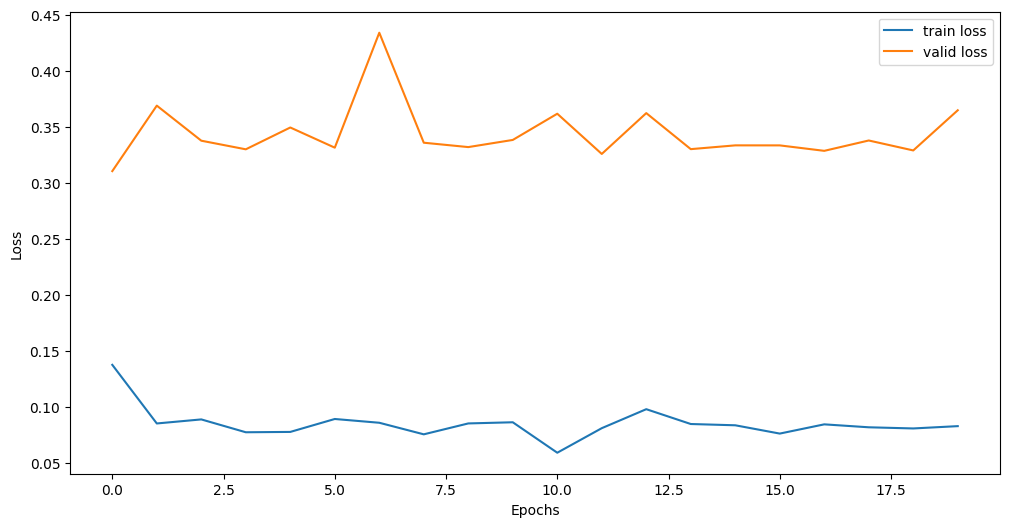

In [52]:
# plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

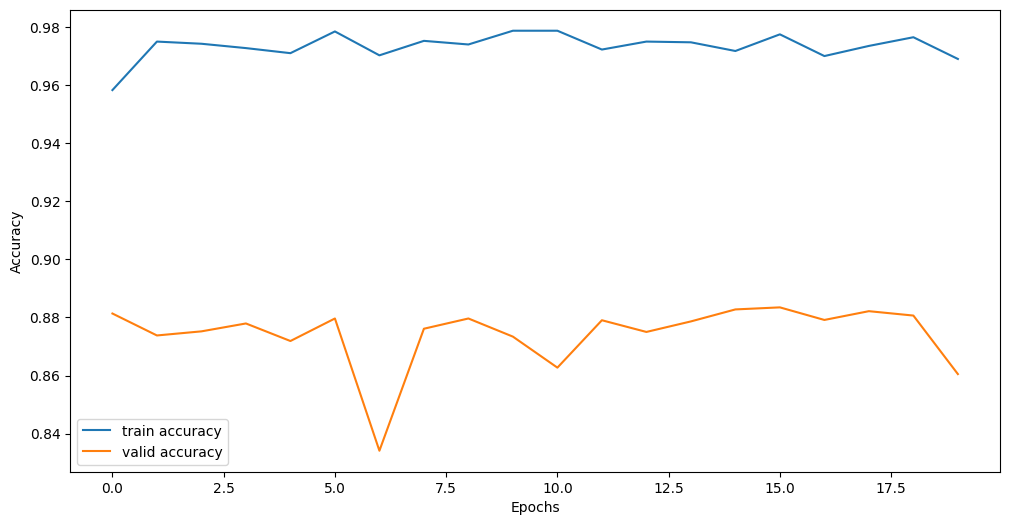

In [53]:
# plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accs, label='train accuracy')
plt.plot(valid_accs, label='valid accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
print("best_loss_eval: ", best_loss_eval)

best_loss_eval:  0.3102602643462328


In [55]:
## Test the model
test_dataset = CustomDataset(test_df, vn_tokenizer, vocabulary)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

test_acc, test_loss = evaluate(model, criterion, test_loader, device)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

C:\Users\Huy\AppData\Local\Temp\ipykernel_22592\2079661315.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)


Test accuracy: 0.8813627658502167, Test loss: 0.3102602643462328


In [ ]:
torch.save(vocabulary, save_model + "vocab_textCNN.pth")

In [61]:
vocab = torch.load("vocab_textCNN.pth")
stoi = vocab
itos = {idx: tok for tok, idx in stoi.items()}
itos

{0: '<unk>',
 1: '<pad>',
 2: 'mua',
 3: 'có',
 4: 'mỗi',
 5: 'bingsu',
 6: 'thập_cẩm',
 7: '45k',
 8: 'mà',
 9: 'mình',
 10: 'f',
 11: 'đợi',
 12: 'hơn',
 13: '20',
 14: "'",
 15: '.',
 16: 'hỏi',
 17: 'lại',
 18: 'thì',
 19: 'nv',
 20: 'trả_lời',
 21: 'r',
 22: 'nhg',
 23: 'bảo',
 24: 'chờ',
 25: 'thêm',
 26: '15',
 27: 'nữa',
 28: '"',
 29: 'tụi',
 30: 'e',
 31: 'lm',
 32: 'liền',
 33: 'không',
 34: 'biết',
 35: 'ngon',
 36: 'cũng',
 37: 'muốn',
 38: 'ăn',
 39: 'thử',
 40: 'thiết_nghĩ',
 41: 'quán',
 42: 'nên',
 43: 'xem_lại',
 44: 'cách',
 45: 'pv',
 46: 'và',
 47: 'nc',
 48: 'vs',
 49: 'khách',
 50: 'thứ',
 51: '6',
 52: 'nào',
 53: 'ta',
 54: 'cùng',
 55: 'quẩy',
 56: ':',
 57: 'bomb',
 58: 'vuvuzela',
 59: 'beer',
 60: 'club',
 61: 'chung',
 62: 'hệ_thống',
 63: 'gogi_house',
 64: ',',
 65: 'daruma',
 66: 'kichi',
 67: 'giá',
 68: 'chưa',
 69: '10',
 70: '%',
 71: 'vat',
 72: 'thanh_toán',
 73: 'trước',
 74: '20g',
 75: 'hằng',
 76: 'ngày',
 77: 'đc',
 78: 'giảm',
 79: '30',
 80

In [62]:
model_loaded = torch.load(save_model + "/textCNN_best_model.pt")
model_loaded

OrderedDict([('embedding.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-0.2899,  0.1319, -0.7448,  ..., -0.4677, -0.2306, -0.3382],
                      [-0.0543,  0.7067,  0.9835,  ...,  0.2093, -0.5960,  0.8719],
                      ...,
                      [-0.1073,  0.2650,  0.1509,  ..., -0.4107, -0.6859, -1.1115],
                      [ 0.4710,  0.5240,  1.9958,  ...,  1.2078, -1.1033,  1.2654],
                      [ 0.5279, -1.1107,  0.4036,  ...,  0.4331, -0.3597, -1.4864]],
                     device='cuda:0')),
             ('conv.0.weight',
              tensor([[[-0.0339, -0.0242],
                       [ 0.0195, -0.0909],
                       [ 0.0824, -0.0844],
                       ...,
                       [-0.0746,  0.0350],
                       [-0.0115,  0.0294],
                       [ 0.0263, -0.0563]],
              
                      [[ 0.0608, -0.0746],
                  